# HMM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import bidict

import literate
import HMM2 as HMM
import poet

In [2]:
syldict = literate.syldict("data/Syllable_dictionary.txt")
data, words = literate.read("data/shakespeare.txt", syldict)
rhymes = literate.get_rhymes(data)

print(len(data), "sonnets\n",
      len(words), "unique words\n",
      len(syldict), "words in dictionary\n",
      len(rhymes), "rhyming words")

154 sonnets
 3205 unique words
 3205 words in dictionary
 1015 rhyming words


In [3]:
wmap = bidict.bidict(enumerate(words)).inv

In [4]:
def toNum(wmap, words):
    return [wmap[w] for w in words]

def toWord(wmap, nums):
    return [wmap.inv[i] for i in nums]

def squash(sonnet):
    return [w for l in sonnet for w in l]

nummed = [toNum(wmap, squash(s)) for s in data]

## Training

In [5]:
nstates = [2,4,8,12,16]
hmms = []
curves = []
for n in nstates:
    print("STATES", n)
    hmm,s = HMM.unsupervised(nummed, N_iters=20, n_states=n)
    hmms.append(hmm)
    curves.append(s)
hmm = hmms[-1]

STATES 2
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 38.712575912475586
STATES 4
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 56.95205235481262
STATES 8
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 93.35388684272766
STATES 12
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 131.97961974143982
STATES 16
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 170.62045097351074


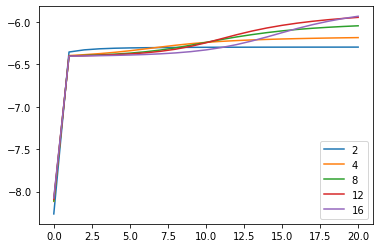

In [6]:
for i,c in zip(nstates,curves):
    plt.plot(c, label=i)
plt.legend()

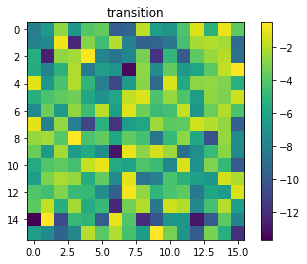

In [7]:
plt.title("transition")
plt.imshow(np.log(hmm.A))
#plt.imshow(hmm.A)
plt.colorbar()

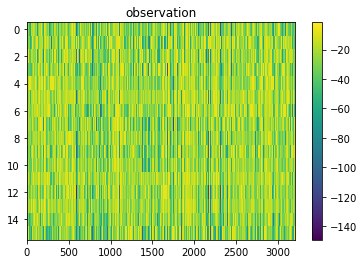

In [8]:
plt.title("observation")
plt.imshow(np.log(hmm.O), aspect='auto')
#plt.imshow(hmm.O, aspect='auto')
plt.colorbar()

In [9]:
HMM.probability_alphas(hmm, nummed[0], log=True)

-639.8975462852216

## Generation

In [10]:
# naive generation
for hmm in hmms:
    print("STATES", hmm.L)
    em, st = HMM.generate_emission(hmm, 140)
    literate.recite(poet.sonnetify(wmap, syldict, em))
    print()

STATES 2
my thus contend time's which one dead best on
though desire bettered which enemies afford
truth we dwellers his accuse o i'll up
died much holds time way ill yet in answered
their full should every water let told me
fingers cheeks let in be bent much your nay
then much thou fever hour my air makes gilding
years joy sweets bosom's as by for not dead
in me never in mine thee we live stands stay
assured twire to doth but of a where o
no yore thou remote those breast for and stars
by maturity by due love loving do
my come with whereon i unless weary
stirred when fixed seen plague heart thou all conceit

STATES 4
slay inhabit that wide cause no such for
calls may eyes departest perfect'st for short-numbered
my friend to music time slave thee that even
no vowed hate poor with bent worth might situation
repay dost hence giving against such all
and mine the sickly wrinkles is to heaven
blushing audit of the blow thy my worth's
thou can friend whate'er and think with and faith
all frie

In [11]:
# the remaining cells will use this hmm
hmm = hmms[-1]

In [12]:
# generate sonnet with constrained syllables and rhyme
sonnet = poet.generate_sonnet(hmm, wmap, rhymes, syldict)
literate.recite(sonnet)

thy is making when beauteous appear to so
nor save nature prevent my common is
gems my love on cheek registers woe th' show
truth and love now eye be i heart to his
poor blind is kissing up in whom not so
you in in skill my proud a ripe with deeds
instinct might thee dost o addeth me grow
thief motion shown heaven nor gain every sheds
weeds to thee not that hawks grecian main not
loves my gentle love thence poison were me
my it till thou doth belong his good plot
mute date the lovely maiden which false be
thy take as love to left see those they it
gone for wrong the my and they once be it


## visualization

In [13]:
def top_words(wmap, hmm, n=10):
    ids = np.argsort(hmm.O, axis=1)[:,-n:]
    words = [
        [wmap.inv[w] for w in s]
        for s in ids
    ]
    return words, np.sort(hmm.O, axis=1)[:,-n:]

In [14]:
top, topprob = top_words(wmap, hmm)

In [15]:
literate.recite([[str(i)]+words for i,words in enumerate(top)])

0 this do on to be are thy when that his
1 did sweet no will do self am have love in
2 where on your now not what their so and thy
3 on yet love like can which is and in thou
4 beauty if that so with is by from but as
5 knows is of but time be in world than not
6 more praise thoughts face love self with no hath heart
7 this but me with and in or for to of
8 when you thy then it is so which and that
9 but give this let be to make all with me
10 do no more shall but should that it thy the
11 live is still her of for such my in i
12 me part time love i thou you not they thee
13 he me thou it not some i be thee that
14 you she own your and thy a the i my
15 do see of a art the o doth to and


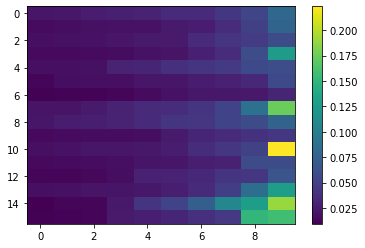

In [16]:
plt.imshow(topprob, aspect="auto")
plt.colorbar()

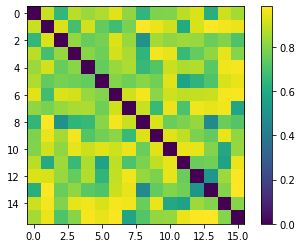

In [17]:
dists = distance.squareform(distance.pdist(hmm.O, "cosine"))
plt.imshow(dists)
plt.colorbar()

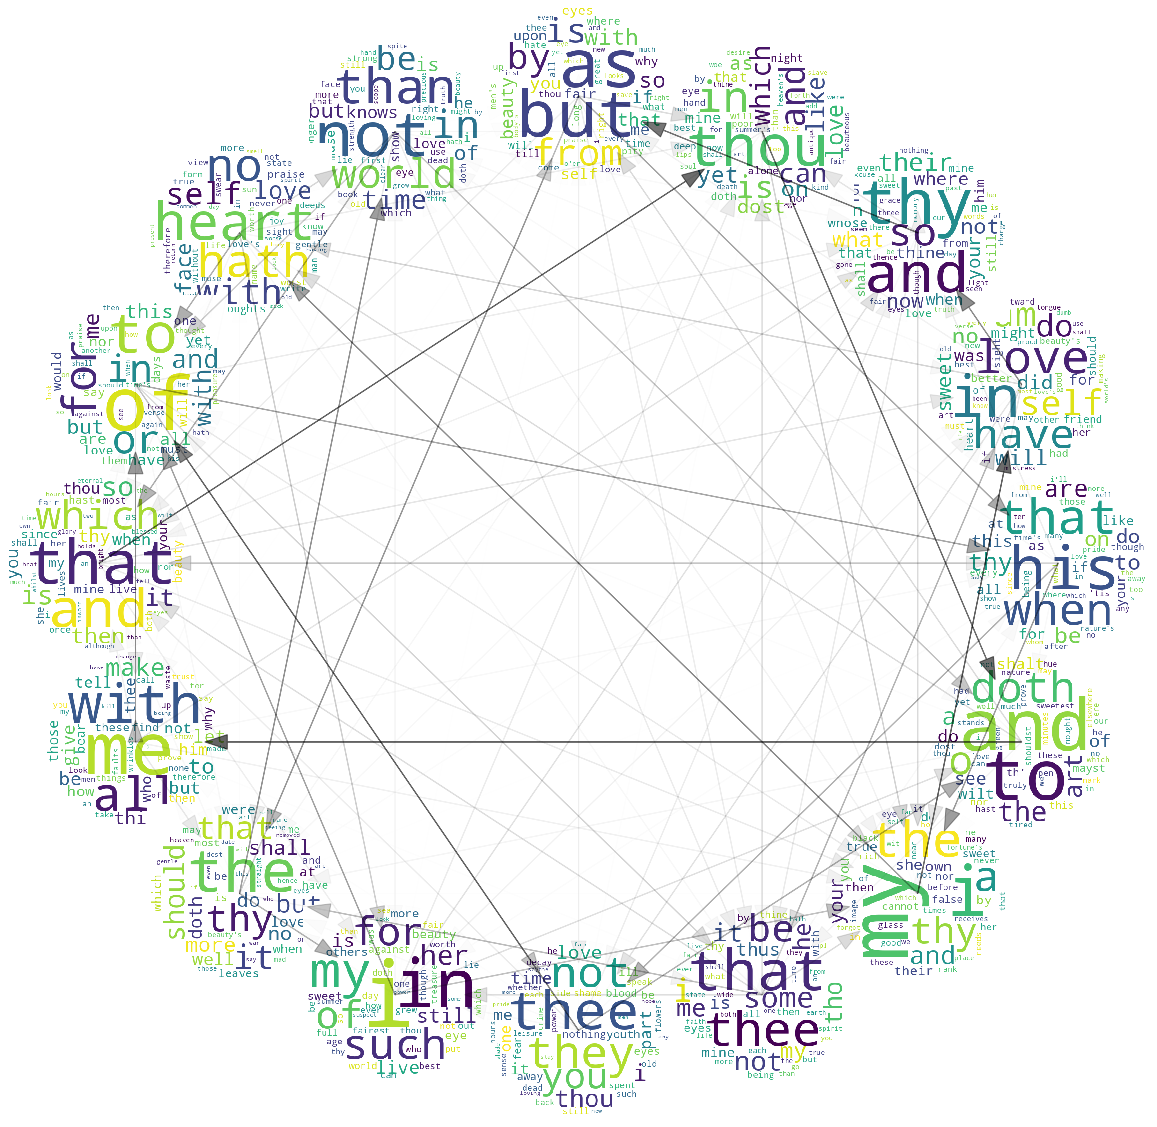

In [20]:
ax = poet.visualize_transitions(wmap, hmm, 1024, 196)